In [2068]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import glob
import cv2

import numpy as np
from skimage import measure, morphology
from skimage.draw import line

from skimage.morphology import remove_small_objects, binary_opening,binary_closing, square, disk
from scipy.stats import linregress

from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


import numpy as np
from skimage.measure import block_reduce

def box_count_from_edge_mask(edge_mask, eps_list):
    # edge_mask: binary (0/1) array with edge pixels = 1
    counts = []
    for eps in eps_list:
        # Reduce by max: a block is "occupied" if any edge pixel is present
        reduced = block_reduce(edge_mask, block_size=(eps, eps),
                               func=np.max, cval=0)
        counts.append(int(reduced.sum()))
    return np.array(counts)


In [1951]:
px_to_um = 0.0376

In [2066]:
def downscale_edge_mask(edge_mask, sc):
    """
    Downscale a binary edge mask by a factor sc (coarser as sc increases).
    sc = 1 -> original size
    """
    if sc == 1:
        return edge_mask.copy()
    
    # Ensure numeric type (uint8)
    edge_mask_uint8 = edge_mask.astype(np.uint8)
    
    original_shape = edge_mask_uint8.shape
    new_shape = (int(original_shape[0] / sc), int(original_shape[1] / sc))
    
    # cv2.resize uses (width, height) for dsize
    downscaled = cv2.resize(edge_mask_uint8, (new_shape[1], new_shape[0]), interpolation=cv2.INTER_NEAREST)
    return downscaled


def resample_contour(contour, n_points):
    """Resample contour to n_points equally spaced along arc length."""
    if len(contour) < 2:
        return contour
    diffs = np.diff(contour, axis=0)
    dists = np.hypot(diffs[:,0], diffs[:,1])
    cumulative = np.concatenate(([0], np.cumsum(dists)))
    target = np.linspace(0, cumulative[-1], n_points)
    new_x = np.interp(target, cumulative, contour[:,0])
    new_y = np.interp(target, cumulative, contour[:,1])
    return np.stack([new_x, new_y], axis=1)

def n_points_from_spacing(contour, ds):
    # compute cumulative arc length
    diffs = np.diff(contour, axis=0)
    dists = np.hypot(diffs[:,0], diffs[:,1])
    L = np.sum(dists)
    n_points = max(2, int(np.ceil(L / ds)))  # at least 2 points
    return n_points

def compute_ds_orig(contours):
    all_spacings = []
    for contour in contours:
        # differences between consecutive points
        diffs = np.diff(contour, axis=0)
        # Euclidean distance between consecutive points
        dists = np.hypot(diffs[:, 0], diffs[:, 1])
        all_spacings.extend(dists)
    
    # Average spacing across all contours
    ds_orig = np.mean(all_spacings)
    return ds_orig


def box_count_from_edge_mask(edge_mask, eps_list):
    # edge_mask: binary (0/1) array with edge pixels = 1
    counts = []
    for eps in eps_list:
        # Reduce by max: a block is "occupied" if any edge pixel is present
        reduced = block_reduce(edge_mask, block_size=(eps, eps),
                               func=np.max, cval=0)
        counts.append(int(reduced.sum()))
    return np.array(counts)


In [188]:
files =glob.glob('*')

In [189]:
imfile = files[0]

In [1070]:
81/3

27.0

506 = frames X channels


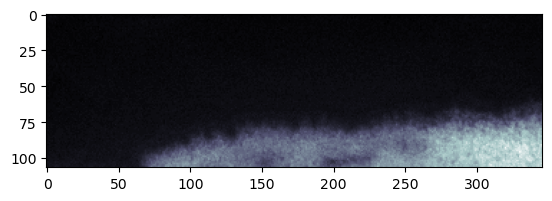

In [1071]:
from celluloid import Camera
fig,ax = plt.subplots()
camera = Camera(fig)



im = Image.open('mTurq_sb7_coliision_for_analysis.tiff')
cnt =0
for i, page in enumerate(ImageSequence.Iterator(im)):
    cnt+=1
    if i ==83:
        arr= np.array(im)
        plt.imshow(arr,cmap='bone')
print(str(i) +  r" = frames X channels")
        

        #plt.imshow(im)

[]

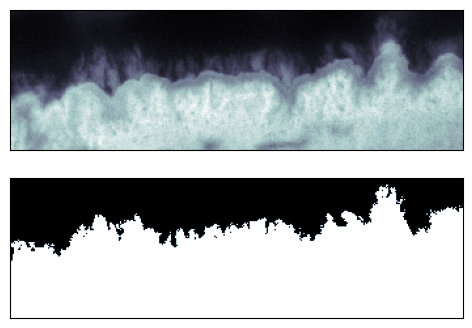

In [191]:
fig,ax=plt.subplots(2,1,figsize=(9,4))
###binarized
arr_bin = np.copy(arr)
arr_bin[arr>15] =255
arr_bin[arr<=15] =0
ax[0].imshow(arr,cmap = 'bone')
cbar = ax[1].imshow(arr_bin,cmap = 'bone')
ax[0].axis('on')
ax[1].axis('on')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])


ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])


In [420]:
#arr = arr.astype(int)
#arr[arr==255] = 1

scale=[1,2,4,6,8,12,16,20,24] ###scale lengths sampled
intLen = np.zeros((170,len(scale))) ###507/3, i.e. just the cyan channel
aProp = np.zeros((170,len(scale)))
tm=0
for i, page in enumerate(ImageSequence.Iterator(im)):
    if i%3==2: ### just the mTurq signal, or the third fluorescne channel
        tm+=1
        arr= np.array(im)
        arr[arr>15] =255###binarize the image
        arr[arr<=15] =0
        
        for s,sc in enumerate(scale):
            res = cv2.resize(arr, dsize=tuple((np.array(arr.shape)/sc).astype(int)[::-1]), interpolation=cv2.INTER_CUBIC)###change from (0,255) to (0,1)
            aProp[tm,s] = np.mean(np.abs((np.max(res)- res)-res)/np.max(res) ) ### take the mean af the array at every scale
            #aProp[tm,s] =np.mean(np.abs((np.max(res)- res)/np.max(res)-res/np.max(res) ))  
            res= res.astype(int) 
            res[res>0]=1 ###integerize

            edges = 4*res - np.roll(res,1,axis=0) - np.roll(res,-1,axis=0)- np.roll(res,1,axis=1)- np.roll(res,1,axis=1) ## find the edge

            edges[edges>0]=0
            edges[edges==-4]=0
            edges[edges<0]=1
            edges[0,:] =0 
            intLen[tm,s]=np.sum(edges) ###find the interface lengrth
            #aProp[tm,s] = np.mean(arr/np.max())
            #np.sum(edges)
            #intLen.append(np.sum(edges))
            #plt.scatter(i,np.sum(edges))

            #plt.yscale('log')
            #plt.xscale('log')

/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/3490668125.py:17: RuntimeWarning: invalid value encountered in divide
  aProp[tm,s] = np.mean(np.abs((np.max(res)- res)-res)/np.max(res) ) ### take the mean af the array at every scale


Text(0, 0.5, '$D$ ')

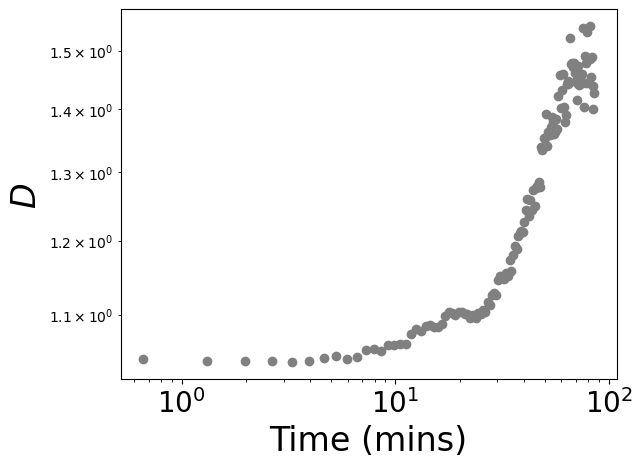

In [421]:
fig,ax = plt.subplots()
for i in range(40,170):
    m,b = np.polyfit(np.log(scale), np.log(intLen[i]),1)
    ax.scatter((i-40)*.66,-m,color='gray')
    

ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)

ax.set_xlabel('Time (mins)',fontsize=24)

ax.set_ylabel('$D$ ',fontsize=24)

/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/1398449394.py:2: RuntimeWarning: divide by zero encountered in log
  m,b = np.polyfit(np.log(scale), np.log(intLen[i]),1)


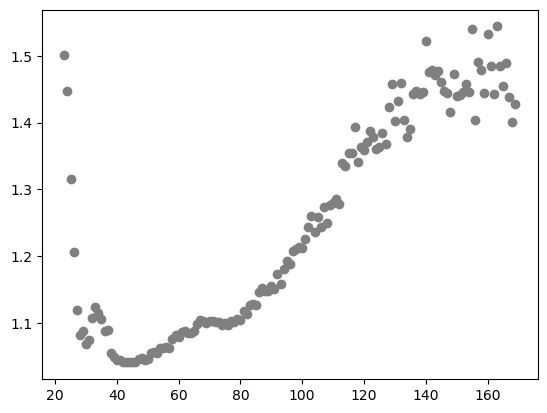

In [126]:
for i in range(170):
    m,b = np.polyfit(np.log(scale), np.log(intLen[i]),1)
    plt.scatter(i,-m,color='gray')
    


In [127]:
intLen[-1]

array([600., 252., 100.,  61.,  46.,  27.,  18.,  10.,   4.])

In [128]:
arr

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

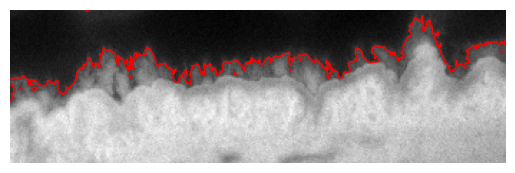

In [1500]:
arr= np.array(im)

contours = measure.find_contours(np.array(im), level=16)
cleaned = morphology.remove_small_objects(arr, min_size=1)
contours = measure.find_contours(cleaned, level=thresh)

plt.imshow(np.array(im), cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], 'r-', linewidth=1)
#plt.title("Contours at intensity=100")
plt.axis('off')
plt.show()

In [129]:
# threshold input image as mask
mask = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# save resulting masked image
#cv2.imwrite('person_transp_bckgrnd.png', result)

# display result, though it won't show transparency
#cv2.imshow("INPUT", img)
#cv2.imshow("GRAY", gray)
#cv2.imshow("MASK", mask)
#cv2.imshow("RESULT", result)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

NameError: name 'img' is not defined

In [2247]:
#arr = arr.astype(int)
#arr[arr==255] = 1
f_frame= 170
scale=[2,4,8,12,24,36,48,72] ###scale lengths sampled
intLen = np.zeros((f_frame,len(scale))) ###507/3, i.e. just the cyan channel
aProp = np.zeros((f_frame,len(scale)))
thresh = 14
tm=0
for i, page in enumerate(ImageSequence.Iterator(im)):
    if ((i%3==2) and i/3<(f_frame)) : ### just the mTurq signal, or the third fluorescne channel
        tm+=1
        arr= np.array(im)[3:,:]

        
        
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=13)
            
        edges = np.zeros_like(cleaned, dtype=np.uint8)
        for contour in contours:
            rr, cc = contour.astype(int).T
            edges[rr, cc] = 1
            #edges_clo=  binary_opening(edges.astype(bool), footprint=square(3))    
            #edges_clo=  binary_closing(edges.astype(bool), footprint=square(1))
            #edges_cln= remove_small_objects(edges_clo.astype(bool), min_size=3)
            edges_cln=edges
            
            intLen[tm,:]=box_count_from_edge_mask(edges_cln, scale)



In [2113]:
48*2

96

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/1035813671.py:109: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  square = plt.Rectangle((300, 90), 500*px_to_um, 4, fill=True,color='black', edgecolor="black", linewidth=0,clip_on = False)


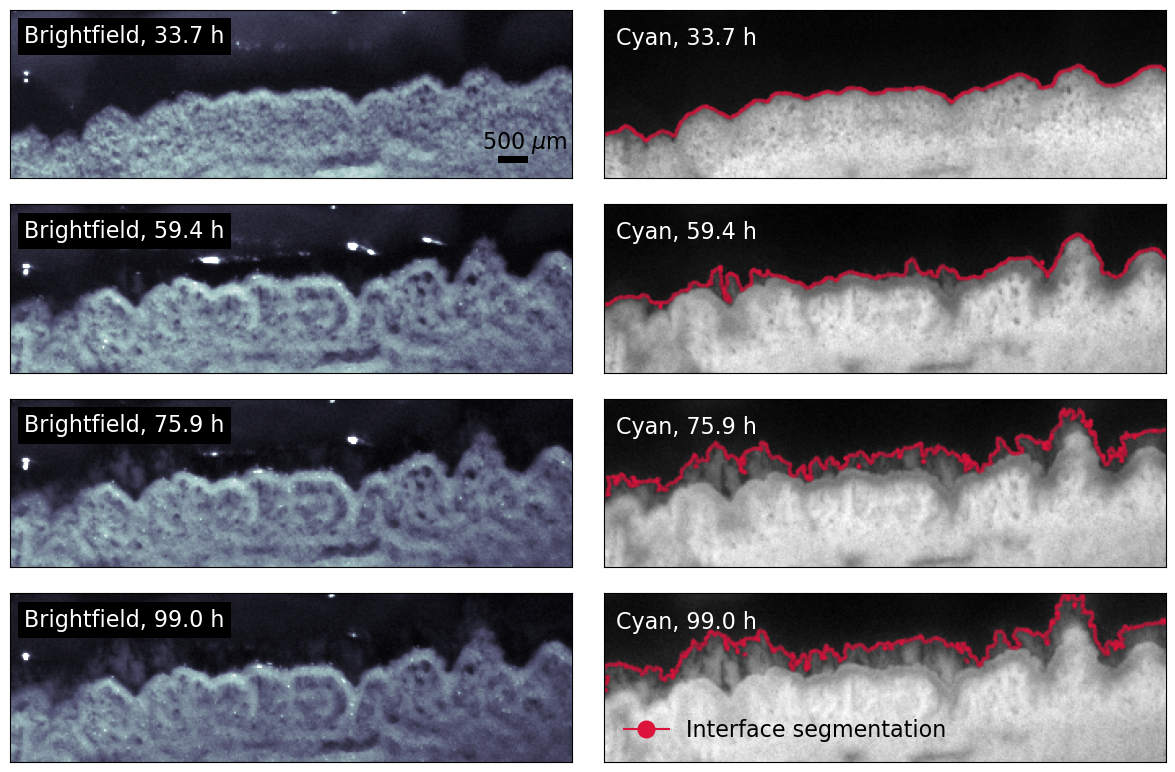

In [2311]:
#arr = arr.astype(int)
#arr[arr==255] = 1
f_frame= 170
scale=[1,2,4,8,12,24] ###scale lengths sampled
intLen = np.zeros((f_frame,len(scale))) ###507/3, i.e. just the cyan channel
aProp = np.zeros((f_frame,len(scale)))
thresh = 14
tm=0
fig,ax=plt.subplots(4,2,figsize=(12,8))

for i, page in enumerate(ImageSequence.Iterator(im)):
    if i==51*3:
        arr= np.array(im)[3:,:]
        ax[0,0].imshow(arr,cmap='bone',vmin=5,vmax=60)
        
    if i ==(51*3 +2): 
        arr= np.array(im)[3:,:]
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)
        ax[0,1].imshow(arr,cmap='gray')
        for contour in contours:
            rr, cc = contour.T  # rows and columns of the contour
            ax[0,1].scatter(cc, rr, s=5, c='crimson',alpha=.3   )  # cc=x, rr=y, s=size of points
        
        
    if i ==90*3:
        arr= np.array(im)[3:,:]
        ax[1,0].imshow(arr,cmap='bone',vmin=5,vmax=60)
        
    if i ==(90*3 +2): 
        arr= np.array(im)[3:,:]
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)
        ax[1,1].imshow(arr,cmap='gray')
        for contour in contours:
            rr, cc = contour.T  # rows and columns of the contour
            ax[1,1].scatter(cc, rr, s=5, c='crimson', alpha=.3  ) 
            
    if i ==115*3:
        arr= np.array(im)[3:,:]
        ax[2,0].imshow(arr,cmap='bone',vmin=5,vmax=60)
        
    if i ==(115*3 +2): 
        arr= np.array(im)[3:,:]
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)
        ax[2,1].imshow(arr,cmap='gray')
        for contour in contours:
            rr, cc = contour.T  # rows and columns of the contour
            ax[2,1].scatter(cc, rr, s=5, c='crimson', alpha=.3  )    
            
            
            # cc=x, rr=y, s=size of points
        
    if i== 150*3:
        arr= np.array(im)[3:,:]
        ax[3,0].imshow(arr,cmap='bone',vmin=5,vmax=60)
        
    if i ==(150*3 +2): 
        arr= np.array(im)[3:,:]
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)
        ax[3,1].imshow(arr,cmap='gray')
        rr, cc = contours[0].T
        ax[3,1].scatter(cc, rr, s=5, c='crimson', alpha=.3, label= 'Interface mask' )  # cc=x, rr=y, s=size of points
        for contour in contours[1:]:
            rr, cc = contour.T  # rows and columns of the contour
            ax[3,1].scatter(cc, rr, s=5, c='crimson', alpha=.3 )  # cc=x, rr=y, s=size of points
            
ax[2,1].legend(
    fontsize=14,          # legend font size
    frameon=False,        # removes translucent box
    loc="lower left")     # position of legend

legend_elements = [
    Line2D([0], [0], marker='o', color='crimson', label='Interface segmentation',
           markerfacecolor='crimson', markersize=12)  # <-- control legend marker size here
]

# Add legend
ax[3,1].legend(handles=legend_elements, fontsize=16, frameon=False,loc='lower left')  
for x in [0,1,2,3]:
    for y in [0,1]:
        ax[x,y].axis("on")

        ax[x,y].set_xticklabels([])
        ax[x,y].set_yticklabels([])


        ax[x,y].set_xticks([])
        ax[x,y].set_yticks([])

ax[0,0].text(70,16,'Brightfield, ' + str(np.round(51*.66,1)) + ' h',fontsize=16, c='white', 
             ha="center", va="center",bbox=dict(facecolor="black", edgecolor="none", boxstyle="square,pad=0.3"))
ax[1,0].text(70,16,'Brightfield, ' + str(np.round(90*.66,1)) + ' h',fontsize=16, c='white', 
             ha="center", va="center",bbox=dict(facecolor="black", edgecolor="none", boxstyle="square,pad=0.3"))
ax[2,0].text(70,16,'Brightfield, ' + str(np.round(115*.66,1)) + ' h',fontsize=16, c='white', 
             ha="center", va="center",bbox=dict(facecolor="black", edgecolor="none", boxstyle="square,pad=0.3"))
ax[3,0].text(70,16,'Brightfield, ' + str(np.round(150*.66,1)) + ' h',fontsize=16, c='white', 
             ha="center", va="center",bbox=dict(facecolor="black", edgecolor="none", boxstyle="square,pad=0.3"))

ax[0,1].text(7,21,'Cyan, ' + str(np.round(51*.66,1)) + ' h',fontsize=16, c='white')
ax[1,1].text(7,21,'Cyan, ' + str(np.round(90*.66,1)) + ' h',fontsize=16, c='white')
ax[2,1].text(7,21,'Cyan, ' + str(np.round(115*.66,1)) + ' h',fontsize=16, c='white')
ax[3,1].text(7,21,'Cyan, ' + str(np.round(150*.66,1)) + ' h',fontsize=16, c='white')
arr= np.array(im)[3:,:]


square = plt.Rectangle((300, 90), 500*px_to_um, 4, fill=True,color='black', edgecolor="black", linewidth=0,clip_on = False)

ax[0,0].text(290,85,r'500 $\mu$m',fontsize=16)
ax[0,0].add_patch(square)
plt.tight_layout()
plt.savefig('fractal_exp_snap_thesis.pdf')
#plt.tight_layout()

49.333333333333336

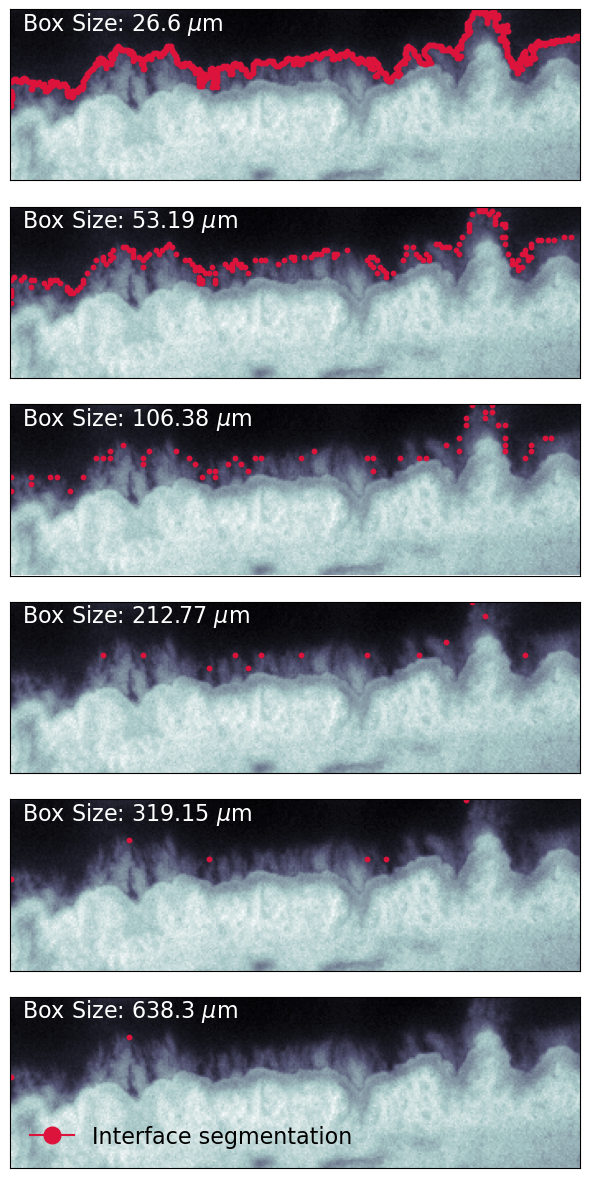

In [2059]:
#arr = arr.astype(int)
#arr[arr==255] = 1
f_frame= 170
scale=[1,2,4,8,12,24] ###scale lengths sampled
intLen = np.zeros((f_frame,len(scale))) ###507/3, i.e. just the cyan channel
aProp = np.zeros((f_frame,len(scale)))
thresh = 14
tm=0
fig,ax=plt.subplots(6,1,figsize=(6,12))

for i, page in enumerate(ImageSequence.Iterator(im)):
    if i==168*3+2:
        arr= np.array(page)[3:,:]
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)
        edges = np.zeros_like(cleaned, dtype=np.uint8)
        for contour in contours:
            rr, cc = contour.astype(int).T
            edges[rr, cc] = 1
            edges_cln =edges
        for s,sc in enumerate(scale):

            edges_sc= cv2.resize(edges_cln, dsize=tuple((np.array(edges_cln.shape)/sc).astype(int)[::-1]), interpolation=cv2.INTER_NEAREST)
            yy, xx = np.nonzero(edges_sc)
            ax[s].imshow(arr,cmap='bone')
            ax[s].scatter(xx*sc,yy*sc, s=10,color='crimson')
            ax[s].axis("on")

            ax[s].set_xticklabels([])
            ax[s].set_yticklabels([])


            ax[s].set_xticks([])
            ax[s].set_yticks([])
            ax[s].text(7,12,'Box Size: ' + str(np.round(sc/px_to_um,2)) + r' $\mu$m', fontsize = 16,color='white')
            
legend_elements = [
    Line2D([0], [0], marker='o', color='crimson', label='Interface segmentation',
           markerfacecolor='crimson', markersize=12)  # <-- control legend marker size here
]

# Add legend
ax[5].legend(handles=legend_elements, fontsize=16, frameon=False,loc='lower left')  
plt.tight_layout()
plt.savefig('segment_boxsize.pdf')

In [2246]:
scale

[2, 4, 8, 12, 24, 36, 48, 72]

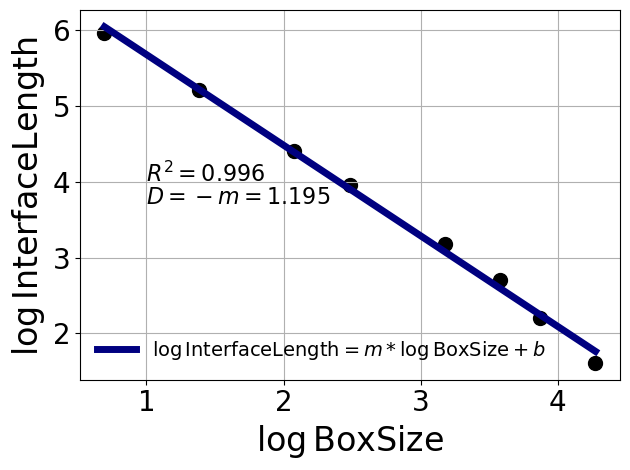

In [2262]:
fig,ax = plt.subplots()


#ax.plot(np.log(scale[:4]), np.log(intLen[169,:4]),lw=5,color = 'navy')
ax.scatter(np.log(scale[:]), np.log(intLen[169,:]),s=100, color= 'k')
m,b = np.polyfit(np.log(scale[:]), np.log(intLen[169,:]),1)
slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[:]), np.log(intLen[169,:]))
#ax.scatter((i-40)*.66,-m,color='gray')
ax.plot(np.log(scale[:]),m*np.log(scale[:])+b,lw=5,color='navy',
        label= '$\log \mathrm{Interface Length} = m * \log \mathrm{Box Size} + b$')


#ax.text('$\log \mathrm{Interface Length} = m * \log \mathrm{Box Size} $' )

ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)

ax.set_xlabel('$\log \mathrm{Box Size}$',fontsize=24)
ax.grid()
ax.set_ylabel('$\log \mathrm{Interface Length}$ ',fontsize=24)
#ax.set_ylim([1.1,2.2])
plt.legend(frameon=False,fontsize=14,loc='best')
ax.text(1,4,r'$R^2 =$' +str(np.round(r_value**2,3)), fontsize=16)
ax.text(1,3.7,r'$D = -m =$' +str(np.round(-m,3)), fontsize=16)
plt.tight_layout()
plt.savefig('D_fit_ex.pdf')

In [2213]:
scale =[1,2, 4, 8, 12, 24, 36, 48, 72, 96]

/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/2365202173.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples


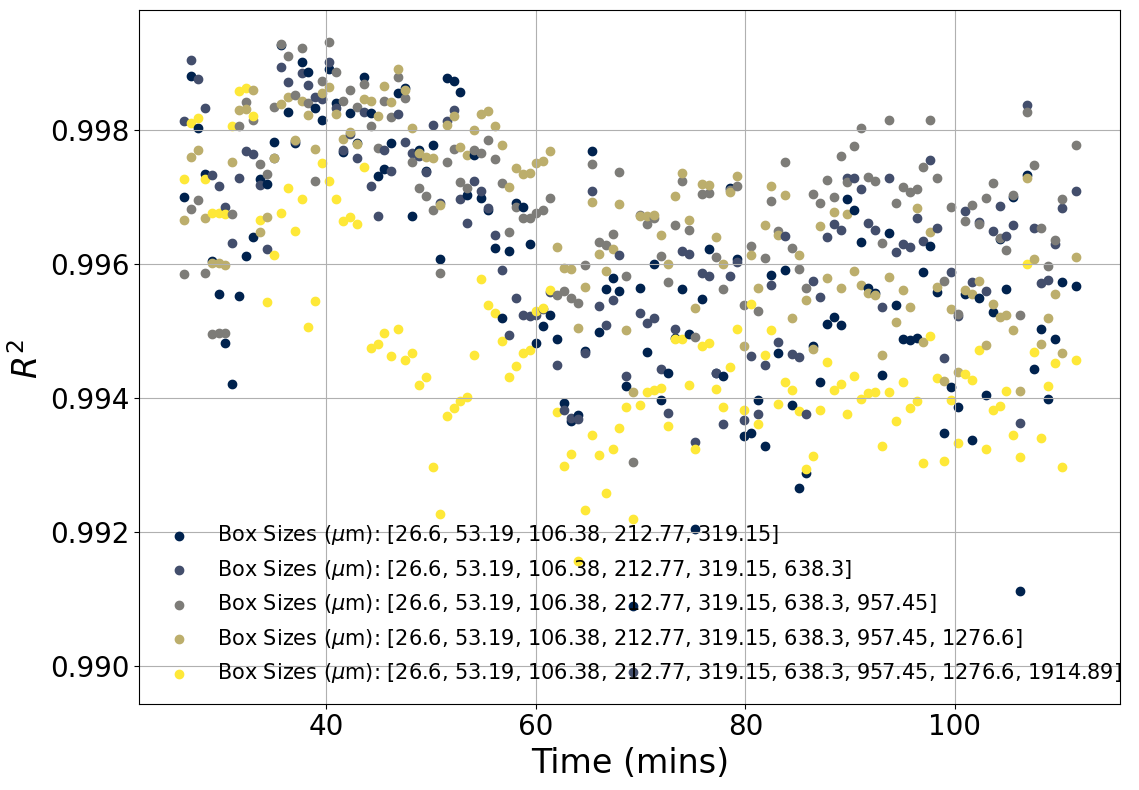

In [2237]:
fig,ax = plt.subplots(figsize=(12,8))

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Number of discrete colors you want
n_colors = len(np.arange(5,len(scale)))
scale_um= [np.round(sc/px_to_um,2) for sc in scale]
# Sample evenly across the colormap
cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples
colors = [cmap(i) for i in range(n_colors)]
for i in range(40,168):
    #m,b = np.polyfit(np.log(scale), np.log(intLen[i,:]),1)
    #ax.scatter((i-40)*.66,-m,color='gray')
    for x,j in enumerate(np.arange(5,len(scale))):
        slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[:j]), np.log(intLen[i,:j]))
        ax.scatter(0.66*i,r_value**2, color=colors[x], )


    
i =169
for x,j in enumerate(np.arange(5,len(scale))):
    slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[:j]), np.log(intLen[i,:j]))
    ax.scatter(0.66*i,r_value**2, color=colors[x],label = 'Box Sizes ($\mu$m): ' + str(scale_um[:j]))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)
plt.legend(frameon=False,fontsize=15 )
ax.set_xlabel('Time (mins)',fontsize=24)
ax.grid()
ax.set_ylabel('$R^2$ ',fontsize=24)
#ax.set_ylim([1.1,2.2])
plt.tight_layout()
plt.savefig('R2_new_thesis_0.pdf')

/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/1688466243.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples


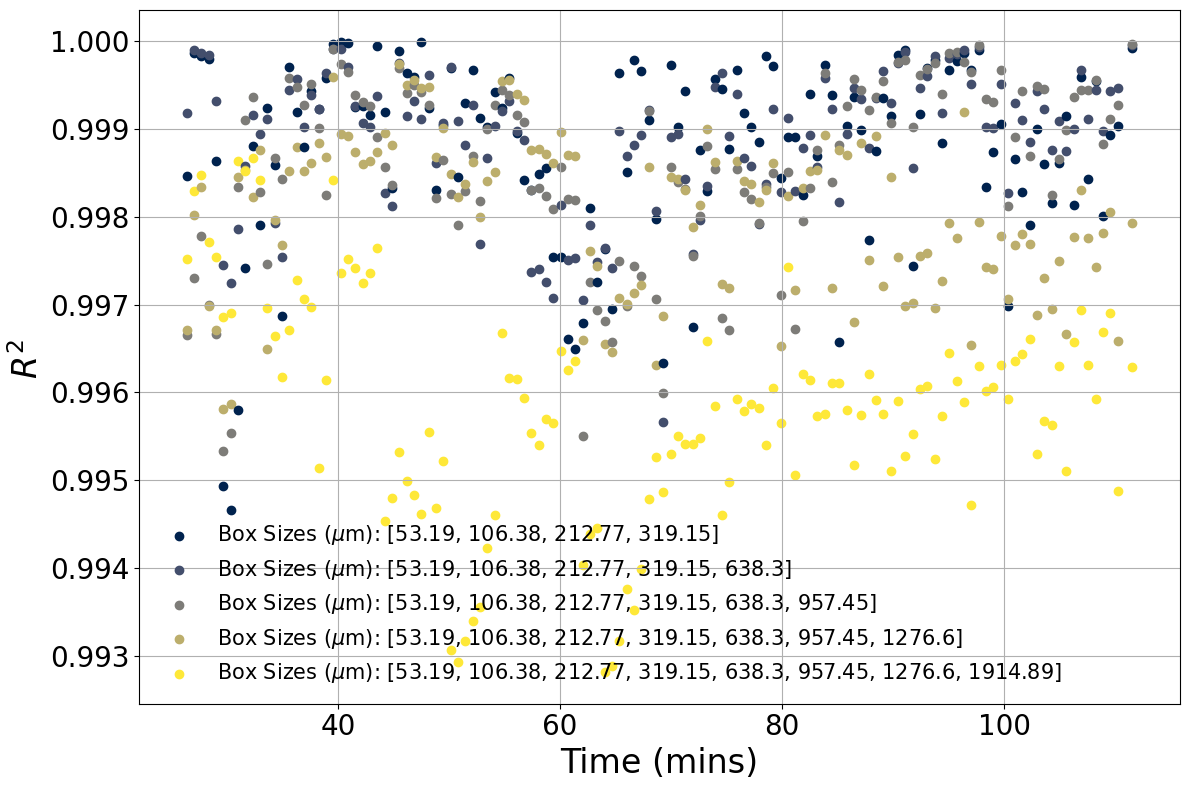

In [2238]:
fig,ax = plt.subplots(figsize=(12,8))

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Number of discrete colors you want
n_colors = len(np.arange(5,len(scale)))
scale_um= [np.round(sc/px_to_um,2) for sc in scale]
# Sample evenly across the colormap
cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples
colors = [cmap(i) for i in range(n_colors)]
for i in range(40,168):
    #m,b = np.polyfit(np.log(scale), np.log(intLen[i,:]),1)
    #ax.scatter((i-40)*.66,-m,color='gray')
    for x,j in enumerate(np.arange(5,len(scale))):
        slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[1:j]), np.log(intLen[i,1:j]))
        ax.scatter(0.66*i,r_value**2, color=colors[x], )


    
i =169
for x,j in enumerate(np.arange(5,len(scale))):
    slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[1:j]), np.log(intLen[i,1:j]))
    ax.scatter(0.66*i,r_value**2, color=colors[x],label = 'Box Sizes ($\mu$m): ' + str(scale_um[1:j]))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)
plt.legend(frameon=False,fontsize=15 )
ax.set_xlabel('Time (mins)',fontsize=24)
ax.grid()
ax.set_ylabel('$R^2$ ',fontsize=24)
#ax.set_ylim([1.1,2.2])
plt.tight_layout()
plt.savefig('R2_new_thesis_1.pdf')

/var/folders/ng/ss707jzs0wd9rf23y3pff_7m0000gn/T/ipykernel_75474/56286887.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples


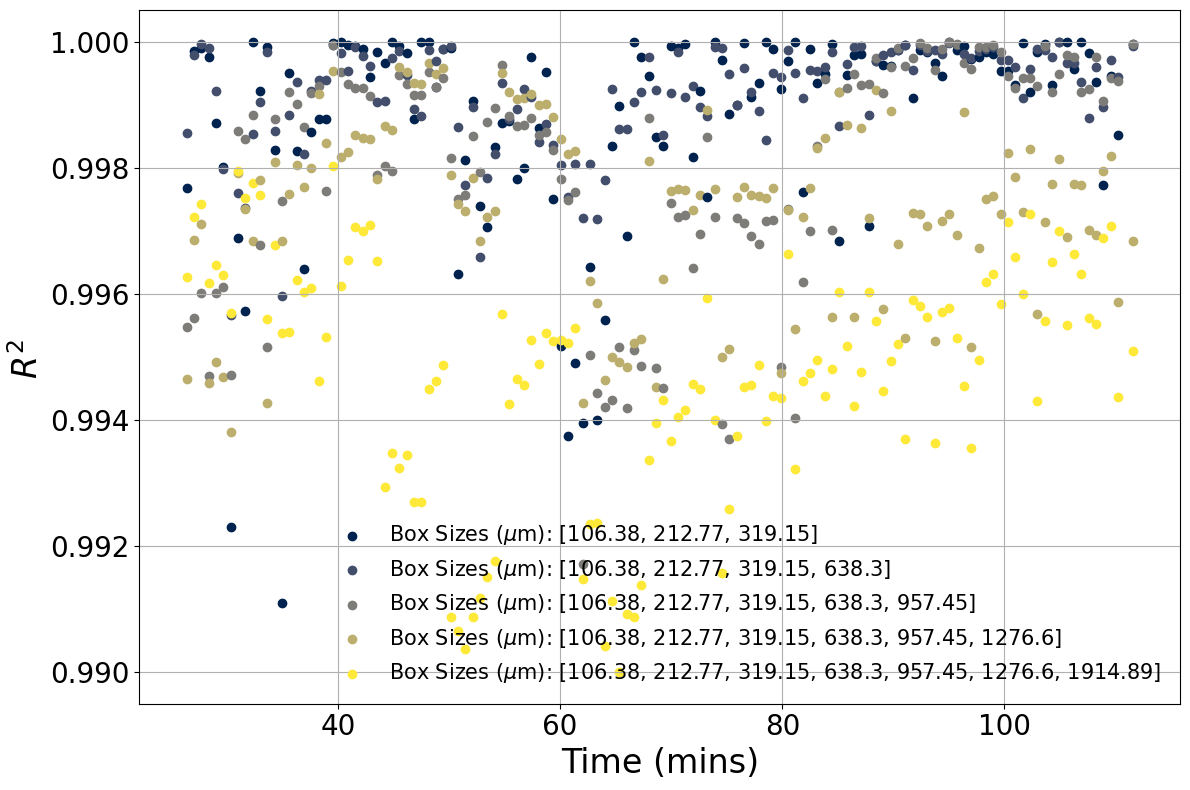

In [2239]:
fig,ax = plt.subplots(figsize=(12,8))

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Number of discrete colors you want
n_colors = len(np.arange(5,len(scale)))
scale_um= [np.round(sc/px_to_um,2) for sc in scale]
# Sample evenly across the colormap
cmap = cm.get_cmap("cividis", n_colors)   # 'n_colors' discrete samples
colors = [cmap(i) for i in range(n_colors)]
for i in range(40,168):
    #m,b = np.polyfit(np.log(scale), np.log(intLen[i,:]),1)
    #ax.scatter((i-40)*.66,-m,color='gray')
    for x,j in enumerate(np.arange(5,len(scale))):
        slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[2:j]), np.log(intLen[i,2:j]))
        ax.scatter(0.66*i,r_value**2, color=colors[x], )


    
i =169
for x,j in enumerate(np.arange(5,len(scale))):
    slope, intercept, r_value, p_value, std_err = linregress(np.log(scale[2:j]), np.log(intLen[i,2:j]))
    ax.scatter(0.66*i,r_value**2, color=colors[x],label = 'Box Sizes ($\mu$m): ' + str(scale_um[2:j]))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)
plt.legend(frameon=False,fontsize=15 )
ax.set_xlabel('Time (mins)',fontsize=24)
ax.grid()
ax.set_ylabel('$R^2$ ',fontsize=24)
#ax.set_ylim([1.1,2.2])
plt.tight_layout()
plt.savefig('R2_new_thesis_2.pdf')

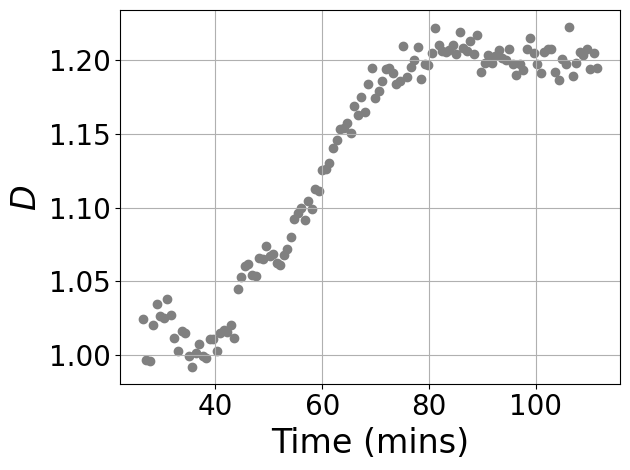

In [2241]:
fig,ax = plt.subplots()
for i in range(40,170):
    m,b = np.polyfit(np.log(scale[:]), np.log(intLen[i,:]),1)
    ax.scatter(0.66*(i),-m,color='gray')
    

#ax.set_xscale('log')
#x.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)

ax.set_xlabel('Time (mins)',fontsize=24)
ax.grid()
ax.set_ylabel('$D$ ',fontsize=24)
#ax.set_ylim([1.1,2.1])
ax.yaxis.set_tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('D_t_new_thesis.pdf')

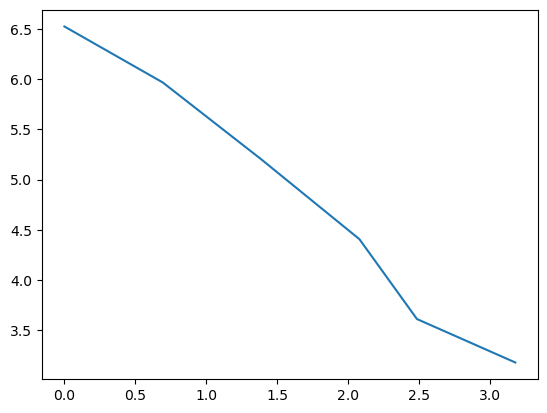

In [2092]:
plt.plot(np.log(scale[:]), np.log(intLen[i,:]))

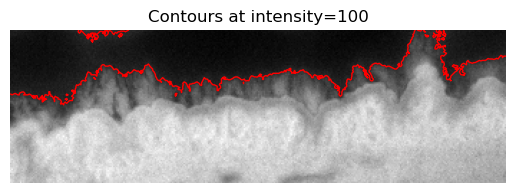

In [705]:
contours = measure.find_contours(np.array(im), level=12)

plt.imshow(np.array(im), cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], 'r-', linewidth=1)
plt.title("Contours at intensity=100")
plt.axis('off')
plt.show()

In [1431]:
#arr = arr.astype(int)
#arr[arr==255] = 1
f_frame= 141
scale=[1,2,4,8,16,32] ###scale lengths sampled
intLen = np.zeros((f_frame,len(scale)))
tps = np.zeros((f_frame,len(scale)))###507/3, i.e. just the cyan channel
aProp = np.zeros((f_frame,len(scale)))
thresh = 16
tm=0
for p, page in enumerate(ImageSequence.Iterator(im)):
    if ((p%3==2) and p/3<(f_frame-1)): ### just the mTurq signal, or the third fluorescne channel
        tm+=1
        arr= np.array(im)
        cleaned = morphology.remove_small_objects(arr, min_size=1)
        contours = measure.find_contours(cleaned, level=thresh)

        all_spacings = []
        for contour in contours:
            diffs = np.diff(contour, axis=0)
            dists = np.hypot(diffs[:,0], diffs[:,1])
            all_spacings.extend(dists)
        ds_orig = 1.0
        

        #print('hi')
        total_points=0 
        for idx, sc in enumerate(scale):
            ds_scaled = ds_orig * sc
            total_length = 0.0
            
            mask_scaled = np.zeros_like(arr, dtype=np.uint8)

            for contour in contours:
                # total arc-length
                diffs = np.diff(contour, axis=0)
                dists = np.hypot(diffs[:,0], diffs[:,1])
                contour_length = np.sum(dists)

                # determine number of resampled points
                n_points = int(np.round(contour_length / ds_scaled))
                #print(sc, n_points)
                if n_points < 2:
                    continue  # skip tiny contours

                # resample contour along arc-length
                s = np.insert(np.cumsum(dists), 0, 0)
                s_uniform = np.linspace(0, contour_length, n_points)
                resampled = np.zeros((n_points, 2))
                resampled[:,0] = np.interp(s_uniform, s, contour[:,0])
                resampled[:,1] = np.interp(s_uniform, s, contour[:,1])

                # compute arc-length of resampled contour
                diffs_resampled = np.diff(resampled, axis=0)
                dists_resampled = np.hypot(diffs_resampled[:,0], diffs_resampled[:,1])
                total_length += np.sum(dists_resampled)
                
            for j in range(len(resampled)-1):
                rr, cc = line(int(resampled[j,0]), int(resampled[j,1]),
                              int(resampled[j+1,0]), int(resampled[j+1,1]))
                rr = np.clip(rr, 0, arr.shape[0]-1)
                cc = np.clip(cc, 0, arr.shape[1]-1)
                mask_scaled[rr, cc] = 1
                total_points += n_points 
            tps[tm,idx] = total_points
            #print(sc,total_points)
            intLen[tm, idx] = total_length
            #print('hi')
            #aProp[tm,s] = np.mean(arr/np.max())
            #np.sum(edges)
            #intLen.append(np.sum(edges))
            #plt.scatter(i,np.sum(edges))

            #plt.yscale('log')
            #plt.xscale('log')

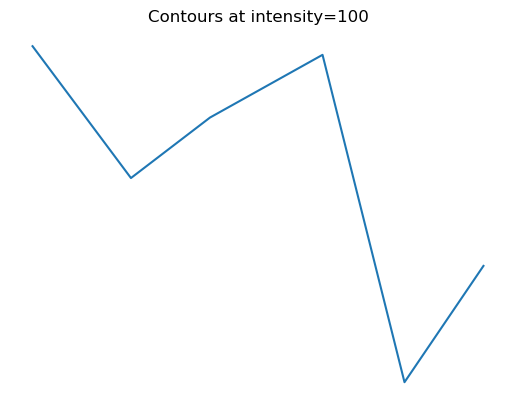

In [1451]:
arr= np.array(im)
sc=128
ds_scaled = ds_orig * sc
total_length = 0.0

mask_scaled = np.zeros_like(arr, dtype=np.uint8)
for contour in contours:
    #plt.plot(contour[:,1],contour[:,0])
    # total arc-length
    diffs = np.diff(contour, axis=0)
    dists = np.hypot(diffs[:,0], diffs[:,1])
    contour_length = np.sum(dists)
    

    # determine number of resampled points
    n_points = int(np.round(contour_length / ds_scaled))
    #print(sc, n_points)
    if n_points < 2:
        continue  # skip tiny contours

    # resample contour along arc-length
    s = np.insert(np.cumsum(dists), 0, 0)
    s_uniform = np.linspace(0, contour_length, n_points)
    resampled = np.zeros((n_points, 2))
    resampled[:,0] = np.interp(s_uniform, s, contour[:,0])
    resampled[:,1] = np.interp(s_uniform, s, contour[:,1])
    plt.plot(resampled[:,1],resampled[:,0])


plt.title("Contours at intensity=100")
plt.axis('off')
plt.show()

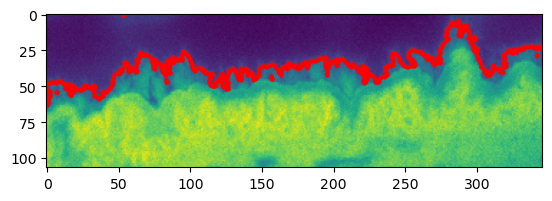

In [1435]:
for contour in contours:
    plt.scatter( contour[:,1],contour[:,0], c='red',s=4)
    # Plot as connected line
    #plt.plot(resampled[:,1], resampled[:,0], '-r', linewidth=1)
    #plt.scatter(resampled[:,1], resampled[:,0], c='red', s=10)  # points
    
plt.imshow(arr)

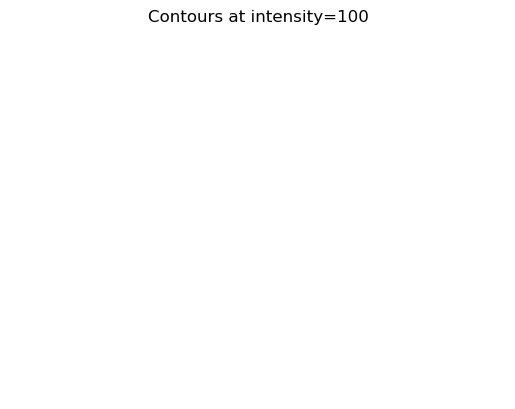

In [1418]:
contours = measure.find_contours(np.array(im), level=16)

#plt.imshow(np.array(im), cmap='gray')
for contour in contours:
    plt.plot(resampled[:, 1], resampled[:, 0], 'r-', linewidth=1)
plt.title("Contours at intensity=100")
plt.axis('off')
plt.show()

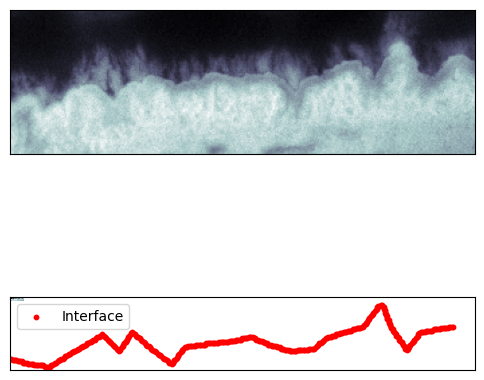

In [1419]:
fig,ax=plt.subplots(2,1,figsize=(6,6))


ax[0].imshow(np.array(im),cmap= 'bone')

y_coords, x_coords = np.where(mask_scaled)
ax[1].imshow(cleaned, cmap= 'bone',interpolation="nearest")  # original binary mask as heatmap
ax[1].scatter(x_coords*sc, y_coords*sc, color="red", s=10, label="Interface")

plt.legend()

for x in [0,1]:
    ax[x].axis("on")

    ax[x].set_xticklabels([])
    ax[x].set_yticklabels([])


    ax[x].set_xticks([])
    ax[x].set_yticks([])

plt.show()

Text(0, 0.5, '$D$ ')

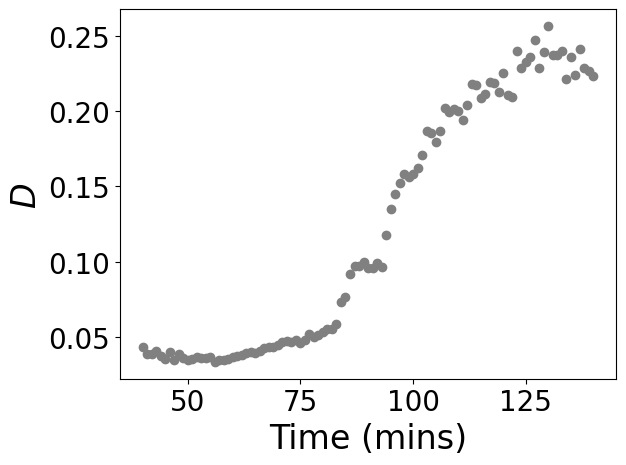

In [1420]:
fig,ax = plt.subplots()
start= 40
for i in range(start,141):
    m,b = np.polyfit(np.log(scale), np.log(intLen[i]),1)
    ax.scatter(i,-m,color='gray')
    

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=20)

ax.yaxis.set_tick_params(labelsize=20)

ax.set_xlabel('Time (mins)',fontsize=24)

ax.set_ylabel('$D$ ',fontsize=24)

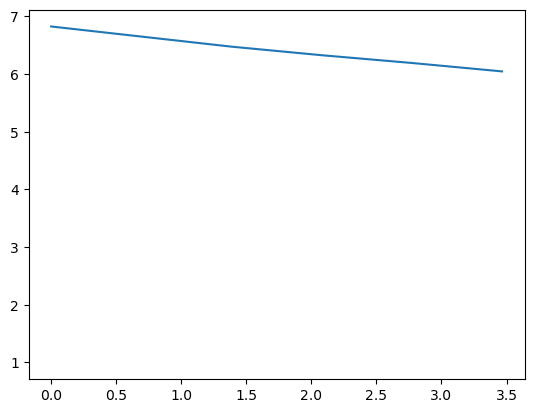

In [1453]:
i=140
plt.plot(np.log(scale), np.log(intLen[i]),1)

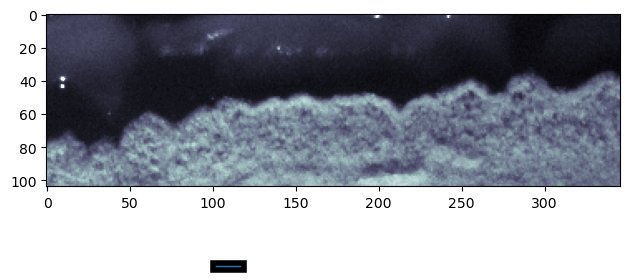

In [2014]:
fix, ax  = plt.subplots()

for i, page in enumerate(ImageSequence.Iterator(im)):
    if i==51*3:
        arr= np.array(im)[3:,:]
        ax.imshow(arr,cmap='bone',vmin=5,vmax=60)
        
        square = plt.Rectangle((100, 150), 500*px_to_um, 4, fill=True, edgecolor="black", linewidth=4,clip_on = False)

# Add square to the axes
ax.add_patch(square)
plt.tight_layout()
plt.savefig('finger_bf_with_scale_bar.pdf')

In [1996]:
arr.shape

(104, 346)

In [2008]:
10/px_to_um

265.9574468085106

In [2010]:
500*px_to_um

9.4

In [2015]:
24/px_to_um

638.2978723404256

In [2016]:
500*px_to_um

18.8

In [2017]:
638/24

26.583333333333332

In [2021]:
346/8

43.25

In [2024]:
tuple((np.array(edges_cln.shape)/sc).astype(int)[::-1])

(14, 4)

In [2025]:
edges_cln.shape

(104, 346)

In [2026]:
sc

24